0.INSTALL INDEPENDENCIES AND BRING IN DATA

In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv(os.path.join('train.csv'))

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


1.PREPROCESS

In [6]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.2.0
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-client               1.9.0
anaconda-navigator            2.1.4
anaconda-project              0.10.2
analytics-python              1.4.0
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backoff                       1.10.0
back

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
MAX_FEATURES = 200000

In [10]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [11]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

2.CREATE SEQUENCIAL MODEL

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [16]:
model = Sequential() 
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [17]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [19]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 22336s 3s/step - loss: 0.0622 - val_loss: 0.0454


In [21]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

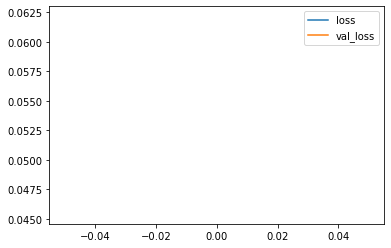

In [22]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

3.MAKE PREDICTIONS

In [23]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [28]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [29]:
batch = test.as_numpy_iterator().next()

In [30]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [31]:
model.predict(np.array([input_text]))

1/1 [==============================] - 0s 281ms/step


array([[0.98297244, 0.08143354, 0.82981515, 0.03323976, 0.6738045 ,
        0.1193677 ]], dtype=float32)

In [54]:
res = model.predict((batch_X))

1/1 [==============================] - 0s 283ms/step


In [59]:
16*6

96

In [58]:
res.shape

(16, 6)

In [33]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [34]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [35]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 219ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [36]:
res.shape

(1, 6)

4.EVALUATE MODEL

In [37]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [52]:
for batch in test.as_numpy_iterator():  
    X_true, y_true = batch 
    yhat = model.predict(X_true)
    
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 169ms/step


In [40]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8807576298713684, Recall:0.6114763617515564, Accuracy:0.4974924921989441


5.TEST AND GRADIO

In [41]:
!pip install gradio jinja2

In [42]:
import tensorflow as tf
import gradio as gr

In [43]:
model.save('toxicity.h5')

In [44]:
model = tf.keras.models.load_model('toxicity.h5')

In [45]:
input_str = vectorizer('hey i freaken hate you!')

In [46]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 1s/step


In [47]:
res

array([[0.73352534, 0.00638513, 0.24800426, 0.01069367, 0.23643117,
        0.04864599]], dtype=float32)

In [48]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [53]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [50]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://58968.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x25355f9ddc0>,
 'http://127.0.0.1:7860/',
 'https://58968.gradio.app')

1/1 [==============================] - 0s 88ms/step
